# pyTorch Convolutional Neural Networks (CNNs)

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import os
import random
import PIL.Image as Image


## Hintergrundinformationen zu CNNs

Convolutional Neural Networks (CNNs) sind eine spezielle Art von künstlichen neuronalen Netzwerken, die besonders gut für die Verarbeitung von Bilddaten geeignet sind. Sie bestehen wie andere neuronale Netze aus mehreren Schichten, darunter Convolutional Layers, Pooling Layers und Fully Connected Layers.

- **Convolutional Layers**: Diese Schichten verwenden Filter (auch als Kernel bezeichnet), um Features im Eingabebild zu erkennen. Dies ermöglicht es dem Netzwerk, Muster wie Kanten, Ecken und Texturen zu erkennen.
- **Pooling Layers**: Diese Schichten reduzieren die räumlichen Dimensionen der Daten, indem sie Informationen zusammenfassen. Dies hilft, die Anzahl der Parameter zu reduzieren und die Rechenleistung zu verbessern.
- **Fully Connected Layers**: Diese Schichten verbinden alle Neuronen der vorherigen Schicht mit allen Neuronen der nächsten Schicht. Sie werden oft am Ende eines CNNs verwendet, um die erkannten Features in eine Klassifikation oder Regression umzuwandeln.

In diesem Notebook werden wir die Grundlagen von CNNs in PyTorch kennenlernen und ein einfaches CNN für die Bildklassifikation implementieren.

### Torch vorbereiten

In [2]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## FER-2013 Dataset vorbereiten, laden und visualisieren

Das FER-2013 Dataset enthält Bilder von Gesichtern, die in verschiedene Emotionen klassifiziert sind. Es ist ein häufig verwendetes Dataset für die Gesichtsemotionserkennung. 
In diesem Abschnitt werden wir das Dataset vorbereiten, laden und einige Beispiele visualisieren.

### Daten laden

In [3]:
data_path = "datasets/FER-2013/"
data_train_path = os.path.join(data_path, "train")
data_test_path = os.path.join(data_path, "test")

In [4]:
train_images = torch.load(os.path.join(data_train_path, "train_images.pt"))
train_labels = torch.load(os.path.join(data_train_path, "train_labels.pt"))
test_images = torch.load(os.path.join(data_test_path, "test_images.pt"))
test_labels = torch.load(os.path.join(data_test_path, "test_labels.pt"))


label_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

reverse_label_mapping = {v: k for k, v in label_mapping.items()}


### Beispielbilder aus dem FER-2013 Dataset visualisieren

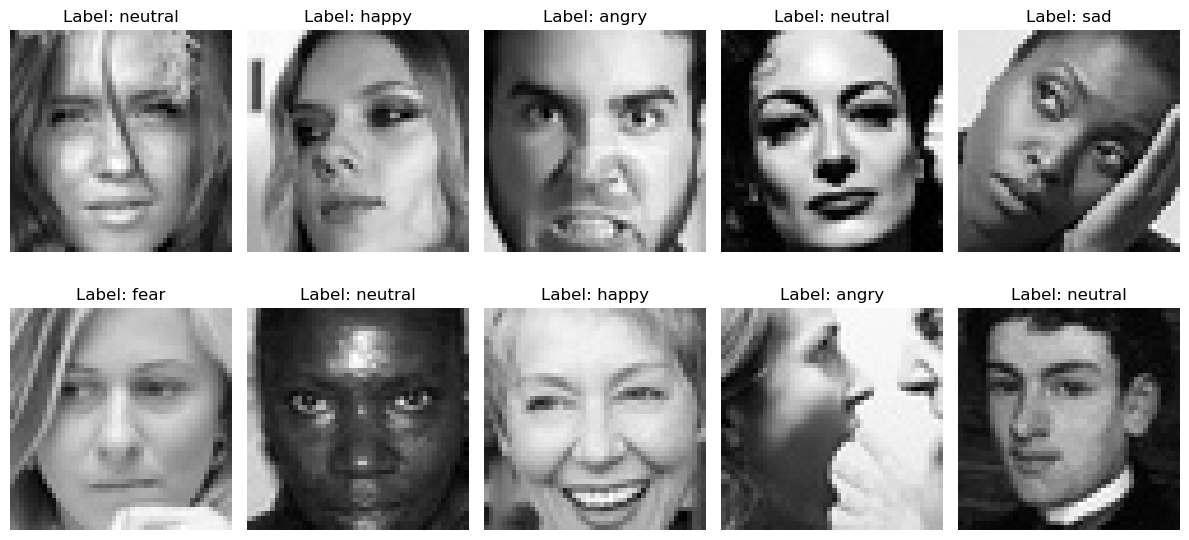

In [5]:
# 10 Beispiele plotten
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    random_index = random.randint(0, len(train_images) - 1)
    ax = axes[i // 5, i % 5]
    ax.imshow(train_images[random_index].squeeze(), cmap='gray')
    ax.set_title(f"Label: {reverse_label_mapping[train_labels[random_index].item()]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Daten validieren

Damit wir die Daten benutzen können, müssen alle Daten gleich formiert sein. Das heisst alle Bilder müssen die gleiche Grösse haben und die Pixelwerte müssen im gleichen Bereich liegen.

In diesem Abschnitt prüfen wir, ob es verschiedene Bildgrössen gibt, ob alle Pixelwerte von 0 bis 255 reichen und zeigen ein Beispiel eines Bildes an.

In [6]:
# Die Anzahl Trainings- und Testdaten anzeigen
print(f"Anzahl Trainingsbilder: {len(train_images)}")
print(f"Anzahl Testbilder: {len(test_images)}")

# Prüfe ob alle Bilder die gleiche Größe haben. Die Bilder sind als Tensoren gespeichert, daher können wir die Form der Tensoren überprüfen.
image_shapes = [image.shape for image in train_images]
unique_shapes = set(image_shapes)
print(f"Einzigartige Bildgrößen: {unique_shapes}")


Anzahl Trainingsbilder: 28709
Anzahl Testbilder: 7178
Einzigartige Bildgrößen: {torch.Size([1, 48, 48])}


#### Prüfen der Pixelwerte und Labels

In [7]:
# Prüfen, dass die Pixelwerte im Bereich von 0 bis 255 liegen. Die Bilder sind als Tensoren gespeichert.
# Wir prüfen die Pixelwerte für alle Bilder, indem wir die Werte der Tensoren extrahieren und in eine flache Liste umwandeln.
temp_train_images_np = train_images.numpy()
assert np.all(temp_train_images_np >= 0) and np.all(temp_train_images_np <= 255)

#### Klassenverteilung überprüfen

In [8]:
# Klassenverteilung überprüfen
list_train_labels = [int(label.item()) for label in train_labels]
list_test_labels = [int(label.item()) for label in test_labels]
print(f"Einzigartige Labels im Training: {set(list_train_labels)}")
print(f"Einzigartige Labels im Testing: {set(list_test_labels)}")

print("-" * 50)
train_label_counts = pd.Series(list_train_labels).value_counts().sort_index()
test_label_counts = pd.Series(list_test_labels).value_counts().sort_index()

print("Klassenverteilung:")
for label, count in train_label_counts.items():
    print(f"Label {reverse_label_mapping[label]}: {count} Trainingsbilder, {test_label_counts[label]} Testbilder")

Einzigartige Labels im Training: {0, 1, 2, 3, 4, 5, 6}
Einzigartige Labels im Testing: {0, 1, 2, 3, 4, 5, 6}
--------------------------------------------------
Klassenverteilung:
Label angry: 3995 Trainingsbilder, 958 Testbilder
Label disgust: 436 Trainingsbilder, 111 Testbilder
Label fear: 4097 Trainingsbilder, 1024 Testbilder
Label happy: 7215 Trainingsbilder, 1774 Testbilder
Label sad: 4830 Trainingsbilder, 1247 Testbilder
Label surprise: 3171 Trainingsbilder, 831 Testbilder
Label neutral: 4965 Trainingsbilder, 1233 Testbilder


### Aufgabe 1: Weitere Validierungsschritte

Auch weitere Validierungsschritte sollten durchgeführt werden.

Prüfen Sie mit Hilfe der Anzeige der Stichproben einige Zellen weiter oben folgende Schritte:

- Sind die Klassen einigermassen gleich verteilt?

> Die Klassen sind recht ungleich verteilt. Vor allem die Klasse "Disgust" ist mit 436 Bildern stark unterrepräsentiert.

- Sind alle Klassen in den Trainings- und Testdaten vorhanden?

> Ja, alle Klassen sind sowohl in den Trainings- als auch in den Testdaten vorhanden.

- Gibt es fehlende Werte (z.B. auch leere Bilder)?

> Es wurden keine fehlenden Werte oder leere Bilder gefunden. Alle Bilder scheinen gültige Daten zu enthalten. Jedoch wäre eine vertiefte Analyse notwendig, um zum Beispiel ganz dunkle oder ganz helle Bilder zu identifizieren, die möglicherweise nicht informativ sind.

- Sind auf allen Bildern tatsächlich Gesichter zu sehen?

> Ja, auf den meisten Bildern sind tatsächlich Gesichter zu sehen. Es gibt jedoch einige Bilder, die möglicherweise nicht klar erkennbare Gesichter oder Stockfoto Texte enthalten, was auf die Qualität der Daten oder die Art der Bilder zurückzuführen sein könnte.

- Sind die Ausschnitte der Bilder sinnvoll und ähnlich (z.B. alle Bilder zeigen das Gesicht von vorne, oder gibt es auch Bilder von der Seite)?

> Die meisten Bilder zeigen das Gesicht von vorne, aber es gibt auch einige Bilder, die Gesichter von der Seite oder in verschiedenen Winkeln zeigen. Dies könnte die Vielfalt der Daten erhöhen, aber es könnte auch die Schwierigkeit der Klassifikation erhöhen, da das Modell möglicherweise Schwierigkeiten hat, verschiedene Ansichten zu generalisieren.

### Data Loader erstellen

In diesem Abschnitt erstellen wir einen Data Loader, um die Daten in Batches zu laden und für das Training vorzubereiten. 
Die Daten sind in Trainings- und Testset aufgeteilt.

In [9]:
# Da die Bilder in einem eigenen Format vorliegen, normalisieren wir die Pixelwerte manuell, indem wir die Pixelwerte durch 255 teilen, um sie in den Bereich von 0 bis 1 zu bringen. Dies ist wichtig, damit das Training stabiler und schneller lernt.

# Wir müssen hier die Bilder normalisieren, da die Pixelwerte im Bereich 0 bis 255 liegen. Wir teilen die Pixelwerte dementsprechend durch 255.
train_images_tensors = train_images.float() / 255.0
test_images_tensors = test_images.float() / 255.0

# Data Loader erstellen
train_loader = DataLoader(list(zip(train_images_tensors, train_labels)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(test_images_tensors, test_labels)), batch_size=64, shuffle=False)


## Neural Network Architektur definieren

In diesem Abschnitt definieren wir die Architektur unseres Convolutional Neural Networks. 

Wir werden mehrere Convolutional Layers, Pooling Layers und Fully Connected Layers verwenden, um ein Modell zu erstellen, das in der Lage ist, die Bilder im MNIST-Datensatz zu klassifizieren.

### Berechnung der Dimensionen der verschiedenen Layers

In pyTorch müssen wir die Dimensionen der Daten durch die verschiedenen Schichten unseres Netzwerks verfolgen, um die Dimensionen der einzelnen Layers zu konfigurieren.

In diesem Abschnitt berechnen wir die Dimensionen der Daten nach jeder Schicht in unserem CNN.

#### Aufgabe 2

Wir möchten folgende Architektur für unser CNN verwenden:
```
Input (48x48) --> Conv1 (7x7, 12 Kernel, Stride 1, Padding 0) --> Pool1 (2x2, Stride 2) --> Conv2 (5x5, 16 Kernel, Stride 1, Padding 0) --> Pool2 (2x2, Stride 2) --> Flatten --> Fully Connected Layer
```

1. Berechnen Sie die Bildgrösse nach dem ersten Convolutional Layer:

> Hinweis: Überlegen Sie sich wie sich die Bildgrösse mit dem verwendeten Kernel, Padding und Stride verändert.

> Bildgrösse = 48x48, Kernel Size = 7 , Padding = 0, Stride = 1
> Auf jeder Seite des Bildes vermindert der Kernel die Bildgrösse um 3 Pixel. Da wir kein Padding verwenden und der Stride 1 ist, vermindert sich die Bildgrösse um 6 Pixel (3 Pixel auf jeder Seite).
> Output Size = 42x42

2. Berechnen Sie die Bildgrösse nach dem ersten Pooling Layer:
> Pooling Size = 2x2, Stride = 2 --> Die Pooling-Schicht reduziert die Bildgrösse um die Hälfte, da sie 2x2 Bereiche zusammenfasst und der Stride 2 ist.
> Output Size = 21x21

3. Berechnen Sie die Bildgrösse nach dem zweiten Convolutional Layer:
> Kernel Size = 5, Padding = 0, Stride = 1
> Da wir ein Padding von 2 verwenden und die Kernel-Grösse 5 ist, bleibt die Bildgrösse gleich. --> Output Size = 17x17

4. Berechnen Sie die Bildgrösse nach dem zweiten Pooling Layer:
> Pooling Size = 2x2, Stride = 2 --> Die Pooling-Schicht reduziert die Bildgrösse um die Hälfte, da sie 2x2 Bereiche zusammenfasst und der Stride 2 ist. Da 17 Pixel ungerade sind, ist die resultierende Grösse die Hälfte von 17-1 = 8.
> Output Size = 8x8

5. Wie viele Neuronen muss der Fully Connected Layer haben, um die Daten korrekt zu verarbeiten? (Tipp: wir müssen die Anzahl der Kanäle und die Bildgrösse nach dem letzten Pooling Layer berücksichtigen)

> Nach dem zweiten Pooling haben wir 16 Kanäle und die Bildgrösse ist 8x8. Daher müssen wir 16 * 8 * 8 = 1024 Neuronen im Fully Connected Layer haben, um alle Informationen aus den vorherigen Schichten zu verarbeiten.


In [10]:
# TODO erstellen Sie mit torch.nn.sequential ein Convolutional Neural Network mit folgenden Schichten:
# - Convolutional Layer mit einem Eingabe-Kanal, 12 Ausgabekanälen, einem Kernel von 7x7, einem Stride von 1 und einem Padding von 0
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - LeakyRELU Aktivierungsfunktion
# - Convolutional Layer mit 12 Eingabekanälen, 16 Ausgabekanälen, einem Kernel von 5x5, einem Stride von 1 und einem Padding von 2
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - LeakyRELU Aktivierungsfunktion
# - Flatten Layer, um die Daten für den Fully Connected Layer vorzubereiten
# - Fully Connected Layer mit der Anzahl Eingabeneuronen die Sie oben berechnet haben und 10 Ausgabeneuronen.

model_1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*8*8, out_features=7),
)

## Netzwerk trainieren und evaluieren
In diesem Abschnitt trainieren wir unser CNN mit dem MNIST-Datensatz und evaluieren die Leistung des Modells auf dem Testset. Wir werden die Trainings- und Testgenauigkeit berechnen und die Ergebnisse visualisieren.

### Trainingloop

Die Funktion `train_model` trainiert das CNN über eine bestimmte Anzahl von Epochen.

In [11]:
def train_model(model, train_loader, test_loader, optimizer, loss_fn, max_num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(max_num_epochs):
        batch_train_losses = []
        batch_test_losses = []
        for batch in train_loader:
            images, labels = batch

            # Wir verschieben die Bilder und Labels auf die gleiche Hardware wie das Modell (CPU oder GPU)
            images, labels = images.to(device), labels.to(device)

            # Wir setzen den Gradienten zurück für den Forward- und Backward-Pass
            optimizer.zero_grad()

            # Wir berechnen die Vorhersagen des Modells für die aktuellen Bilder
            outputs = model(images)

            # Wir berechnen den Loss
            train_loss = loss_fn(outputs, labels)

            #Wir berechnen die Gradienten und aktualisieren die Gewichte des Modells
            train_loss.backward()
            optimizer.step()
            
            batch_train_losses.append(train_loss.item())

        # Testing Loop mit torch.no_grad(), damit wir keine Gradienten berechnen und somit Speicher sparen
        # Wir berechnen den Testloss für die Testdaten aus dem test_loader
        with torch.no_grad():
            for batch in test_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                batch_test_losses.append(loss_fn(outputs, labels).item())

        training_loss = np.mean(batch_train_losses)
        testing_loss = np.mean(batch_test_losses)
        train_losses.append(training_loss)
        test_losses.append(testing_loss)

        print(f"Epoch {epoch}: Train Loss = {training_loss:.5f}, Test Loss = {testing_loss:.5f}")
    return train_losses, test_losses

In [12]:
def plot_train_test_losses(train_losses, test_losses):
    # Test und Trainingsverluste visualisieren
    plt.plot(train_losses, label='Trainings Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochen')
    plt.ylabel('Loss')
    plt.title('Trainings- und Testverlust über Epochen')
    plt.legend()
    plt.show()

### Model Trainieren

In [13]:
# Hyperparameter definieren
max_num_epochs = 20
learning_rate = 0.001

# Optimizer und die Loss-Funktion definieren
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Das Modell muss noch auf die Hardware verschoben werden.
model_1.to(device)

train_losses, test_losses = train_model(model_1, train_loader, test_loader, optimizer, loss_fn, max_num_epochs)

# Speichern des trainierten Modells
torch.save(model_1.state_dict(), "FER_cnn.pth")

Epoch 0: Train Loss = 1.68914, Test Loss = 1.55029
Epoch 1: Train Loss = 1.51966, Test Loss = 1.45502
Epoch 2: Train Loss = 1.44227, Test Loss = 1.43754
Epoch 3: Train Loss = 1.39214, Test Loss = 1.39329
Epoch 4: Train Loss = 1.35340, Test Loss = 1.36633
Epoch 5: Train Loss = 1.31814, Test Loss = 1.34869
Epoch 6: Train Loss = 1.29308, Test Loss = 1.33484
Epoch 7: Train Loss = 1.27417, Test Loss = 1.32584
Epoch 8: Train Loss = 1.24941, Test Loss = 1.32555
Epoch 9: Train Loss = 1.23642, Test Loss = 1.31302
Epoch 10: Train Loss = 1.22102, Test Loss = 1.32136
Epoch 11: Train Loss = 1.20497, Test Loss = 1.31707
Epoch 12: Train Loss = 1.19149, Test Loss = 1.30798
Epoch 13: Train Loss = 1.17813, Test Loss = 1.30465
Epoch 14: Train Loss = 1.16913, Test Loss = 1.30526
Epoch 15: Train Loss = 1.15957, Test Loss = 1.31966
Epoch 16: Train Loss = 1.15167, Test Loss = 1.33293
Epoch 17: Train Loss = 1.14490, Test Loss = 1.33361
Epoch 18: Train Loss = 1.13437, Test Loss = 1.30673
Epoch 19: Train Loss =

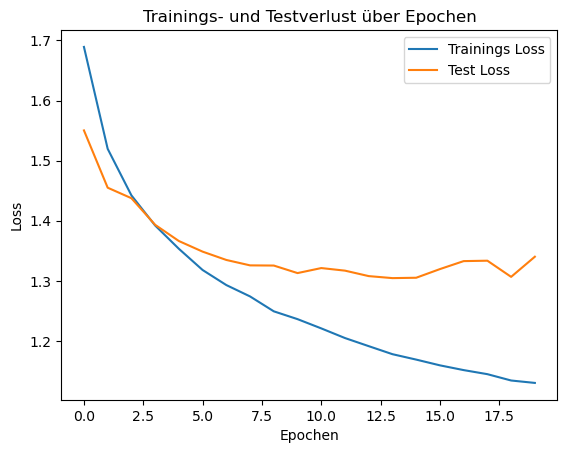

In [14]:
plot_train_test_losses(train_losses,test_losses)

#### Aufgabe 2.1: Fragen zu den Lernkurven im Plot
Was schliessen Sie aus diesen beiden Lernkurven im Plot?

> Die Trainingskurve geht kontinuierlich nach unten, das heisst das Modell lernt immer mehr über die Trainingsdaten. Jedoch stagniert die Testkurve in etwa um Epoche 11, was darauf hindeutet, dass das Modell ab diesem Punkt beginnt, die Trainingsdaten zu überfitten und nicht mehr besser auf den Testdaten generalisiert. Danach steigt die Testkurve sogar wieder leicht an.

### Modell laden

In [15]:
model_1_geladen = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*8*8, out_features=7),
)



# Testen ob das File für das Modell existiert und das Modell geladen werden kann
if os.path.exists("FER_cnn.pth"):
    model_1_geladen.load_state_dict(torch.load("FER_cnn.pth"))
    print("Modell erfolgreich geladen!")


Modell erfolgreich geladen!


### Funktion um die Modell-Accuracy zu berechnen

In [16]:
# Accuracy berechnen

def test_model_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [17]:
print(f"Test Accuracy: {test_model_accuracy(model_1_geladen, test_loader):.2f}%")

Test Accuracy: 50.18%


## Alternative Modelle erstellen

### Aufgabe 3: Andere Modelle erstellen und evaluieren

In diesem Abschnitt erstellen Sie zwei weitere Modelle mit unterschiedlichen Architekturen und vergleichen Sie die Leistung dieser Modelle mit dem ursprünglichen Modell.

#### Modell 2 erstellen, trainieren und speichern

In [18]:
# Model 2: Ein tieferes CNN mit mehr Filtern und mehr linearen Layers. Spezialität: Zwei Conv-Layers ohne Pooling.
model_2 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(in_features=128, out_features=7),
)

print("Model 2 Architektur:")
print(model_2)

Model 2 Architektur:
Sequential(
  (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4608, out_features=128, bias=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): Linear(in_features=128, out_features=7, bias=True)
)



=== Training Model 2 ===
Epoch 0: Train Loss = 1.62181, Test Loss = 1.47422
Epoch 1: Train Loss = 1.40859, Test Loss = 1.35849
Epoch 2: Train Loss = 1.28389, Test Loss = 1.27550
Epoch 3: Train Loss = 1.15778, Test Loss = 1.24123
Epoch 4: Train Loss = 1.02258, Test Loss = 1.27568
Epoch 5: Train Loss = 0.85924, Test Loss = 1.30971
Epoch 6: Train Loss = 0.67154, Test Loss = 1.44565
Epoch 7: Train Loss = 0.48617, Test Loss = 1.68671
Epoch 8: Train Loss = 0.31314, Test Loss = 1.97761
Epoch 9: Train Loss = 0.19418, Test Loss = 2.42660
Epoch 10: Train Loss = 0.12372, Test Loss = 2.91026
Epoch 11: Train Loss = 0.10784, Test Loss = 2.88699
Epoch 12: Train Loss = 0.08312, Test Loss = 3.21443
Epoch 13: Train Loss = 0.08181, Test Loss = 3.33294
Epoch 14: Train Loss = 0.08642, Test Loss = 3.42940
Epoch 15: Train Loss = 0.06558, Test Loss = 3.55235
Epoch 16: Train Loss = 0.05033, Test Loss = 3.52237
Epoch 17: Train Loss = 0.05284, Test Loss = 3.60959
Epoch 18: Train Loss = 0.06793, Test Loss = 3.60

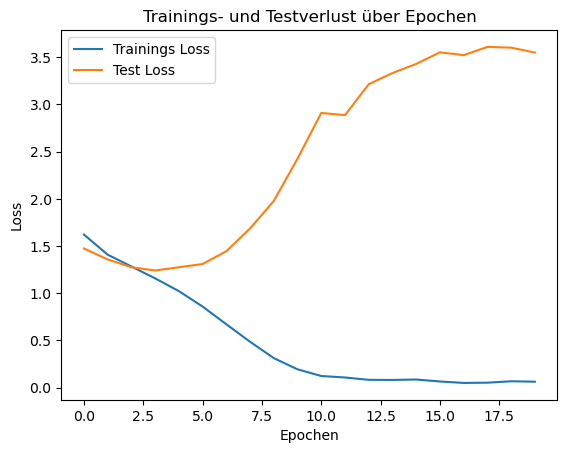

In [19]:
# Model 2 trainieren
model_2.to(device)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
loss_fn_2 = torch.nn.CrossEntropyLoss()

print("\n=== Training Model 2 ===")
train_losses_2, test_losses_2 = train_model(model_2, train_loader, test_loader, optimizer_2, loss_fn_2, max_num_epochs)

# Model 2 speichern
torch.save(model_2.state_dict(), "FER_cnn_model_2.pth")
print("Model 2 gespeichert!")

plot_train_test_losses(train_losses_2,test_losses_2)

**Oben:** In diesem Diagramm sehen wir wie das Modell extrem auf die Trainingsdaten overfitted und auf den Testdaten wieder schlechter wird.

#### Modell 3 erstellen, trainieren und speichern

In [20]:
# Model 3: Ein kompakteres CNN mit weniger Filtern und kleineren Kernel und einem Linear Layer. Eine Andere Aktivierungsfunktion wird genutzt.
model_3 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=7),
)

print("Model 3 Architektur:")
print(model_3)

Model 3 Architektur:
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Sigmoid()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4608, out_features=7, bias=True)
)



=== Training Model 3 ===
Epoch 0: Train Loss = 1.82935, Test Loss = 1.81680
Epoch 1: Train Loss = 1.79766, Test Loss = 1.78792
Epoch 2: Train Loss = 1.77389, Test Loss = 1.77640
Epoch 3: Train Loss = 1.74038, Test Loss = 1.71299
Epoch 4: Train Loss = 1.70002, Test Loss = 1.67272
Epoch 5: Train Loss = 1.66968, Test Loss = 1.66145
Epoch 6: Train Loss = 1.65288, Test Loss = 1.64226
Epoch 7: Train Loss = 1.63585, Test Loss = 1.63349
Epoch 8: Train Loss = 1.62243, Test Loss = 1.61875
Epoch 9: Train Loss = 1.61154, Test Loss = 1.61149
Epoch 10: Train Loss = 1.59797, Test Loss = 1.60509
Epoch 11: Train Loss = 1.58367, Test Loss = 1.58460
Epoch 12: Train Loss = 1.56806, Test Loss = 1.59027
Epoch 13: Train Loss = 1.55681, Test Loss = 1.57750
Epoch 14: Train Loss = 1.54027, Test Loss = 1.56315
Epoch 15: Train Loss = 1.52593, Test Loss = 1.57380
Epoch 16: Train Loss = 1.51540, Test Loss = 1.54032
Epoch 17: Train Loss = 1.50172, Test Loss = 1.53205
Epoch 18: Train Loss = 1.49041, Test Loss = 1.53

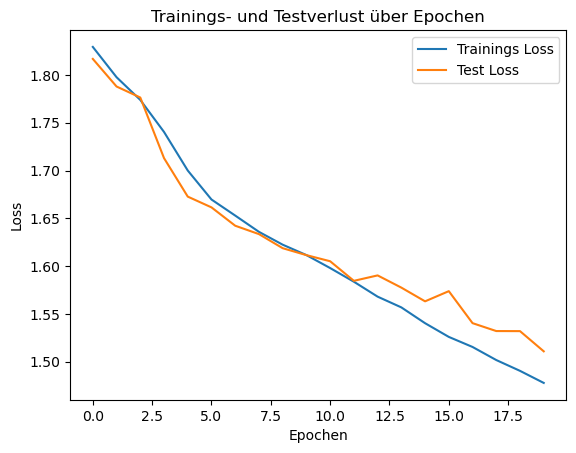

In [21]:
# Model 3 trainieren
model_3.to(device)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=learning_rate)
loss_fn_3 = torch.nn.CrossEntropyLoss()

print("\n=== Training Model 3 ===")
train_losses_3, test_losses_3 = train_model(model_3, train_loader, test_loader, optimizer_3, loss_fn_3, max_num_epochs)

# Model 3 speichern
torch.save(model_3.state_dict(), "FER_cnn_model_3.pth")
print("Model 3 gespeichert!")

# Visualisierung der Trainings- und Testverluste
plot_train_test_losses(train_losses_3,test_losses_3)

<div style="padding: 5px; border: 5px solid #a10000ff;">
<h2 style="color: red;">Behalten Sie die Dateien (.pth) der drei gespeicherten Modelle für nächste Woche!</h2>

Wir werden die Modelle nächste Woche, genauer auswerten und benötigen deshalb die Modelle.

### Auswertung der Modelle anzeigen


=== Laden und Evaluieren aller Modelle ===

Model 1 Test Accuracy: 50.18%
Model 2 Test Accuracy: 51.88%
Model 3 Test Accuracy: 42.32%

=== Zusammenfassung ===


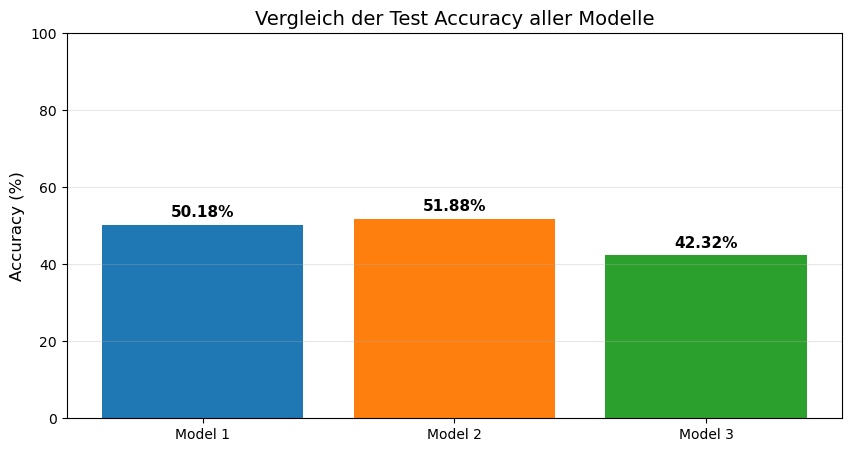

In [22]:
# Alle Modelle laden und Accuracy vergleichen
print("\n=== Laden und Evaluieren aller Modelle ===\n")

# ----------------------------------------------------------------------
# Model 1 laden
# ----------------------------------------------------------------------
model_1_final = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*8*8, out_features=7),
)
if os.path.exists("FER_cnn.pth"):
    model_1_final.load_state_dict(torch.load("FER_cnn.pth"))
    model_1_final.to(device)
    accuracy_1 = test_model_accuracy(model_1_final, test_loader)
    print(f"Model 1 Test Accuracy: {accuracy_1:.2f}%")

# ----------------------------------------------------------------------
# Model 2 laden
# ----------------------------------------------------------------------
model_2_final = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(in_features=128, out_features=7),
)
if os.path.exists("FER_cnn_model_2.pth"):
    model_2_final.load_state_dict(torch.load("FER_cnn_model_2.pth"))
    model_2_final.to(device)
    accuracy_2 = test_model_accuracy(model_2_final, test_loader)
    print(f"Model 2 Test Accuracy: {accuracy_2:.2f}%")

# ----------------------------------------------------------------------
# Model 3 laden
# ----------------------------------------------------------------------

model_3_final = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=7),
)
if os.path.exists("FER_cnn_model_3.pth"):
    model_3_final.load_state_dict(torch.load("FER_cnn_model_3.pth"))
    model_3_final.to(device)
    accuracy_3 = test_model_accuracy(model_3_final, test_loader)
    print(f"Model 3 Test Accuracy: {accuracy_3:.2f}%")

# Vergleich visualisieren
print("\n=== Zusammenfassung ===")
accuracies = [accuracy_1, accuracy_2, accuracy_3]
models = ['Model 1', 'Model 2', 'Model 3']

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Vergleich der Test Accuracy aller Modelle', fontsize=14)
plt.ylim([0, 100])
for i, v in enumerate(accuracies):
    plt.text(i, v + 2, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Optional: Aufgabe 4 mit Grid-Search für Hyperparameter
In diesem Abschnitt können Sie eine Grid-Search durchführen, um die besten Hyperparameter für Ihr Modell zu finden. Sie können verschiedene Werte für die Lernrate, die Anzahl der Epochen, die Batch-Grösse und andere Hyperparameter ausprobieren und die Leistung des Modells vergleichen.

=== Grid Search für Model 1 Hyperparameter ===

Teste 3 Learning Rates: [0.001, 0.0005, 0.0001]
Teste 3 Epochenzahlen: [5, 10, 20]
Gesamtanzahl Kombinationen: 9


Training mit: Learning Rate = 0.001, Epochs = 5
Epoch 0: Train Loss = 1.68364, Test Loss = 1.58460
Epoch 1: Train Loss = 1.54281, Test Loss = 1.49063
Epoch 2: Train Loss = 1.47278, Test Loss = 1.45131
Epoch 3: Train Loss = 1.41821, Test Loss = 1.42113
Epoch 4: Train Loss = 1.37511, Test Loss = 1.38027

Ergebnis: Test Accuracy = 47.73%
Final Train Loss = 1.37511, Final Test Loss = 1.38027

Training mit: Learning Rate = 0.001, Epochs = 10
Epoch 0: Train Loss = 1.68263, Test Loss = 1.61751
Epoch 1: Train Loss = 1.55565, Test Loss = 1.50985
Epoch 2: Train Loss = 1.48865, Test Loss = 1.46617
Epoch 3: Train Loss = 1.43527, Test Loss = 1.43784
Epoch 4: Train Loss = 1.39353, Test Loss = 1.39283
Epoch 5: Train Loss = 1.36173, Test Loss = 1.38945
Epoch 6: Train Loss = 1.33313, Test Loss = 1.37999
Epoch 7: Train Loss = 1.31110, Test Los

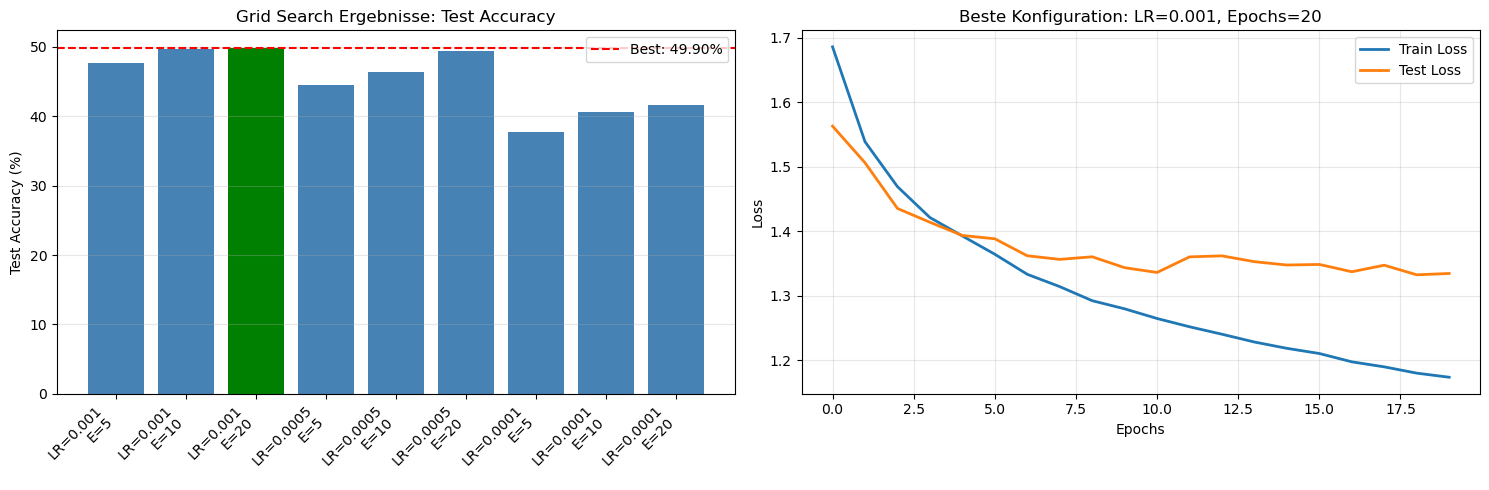


Möchten Sie das beste Modell neu trainieren und speichern?
(Setzen Sie save_best_model = True um das Modell zu speichern)


In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]
number_of_epochs = [5, 10, 20]

# Wichtig: Um faire Vergleiche zu ermöglichen, erstellen wir für jede Kombination ein neues Modell (anstatt ein bereits trainiertes Modell weiterzutrainieren)

print("=== Grid Search für Model 1 Hyperparameter ===\n")
print(f"Teste {len(learning_rates)} Learning Rates: {learning_rates}")
print(f"Teste {len(number_of_epochs)} Epochenzahlen: {number_of_epochs}")
print(f"Gesamtanzahl Kombinationen: {len(learning_rates) * len(number_of_epochs)}\n")

# Dictionary um die Ergebnisse zu speichern
results = []

# Durchlaufe alle Kombinationen von Hyperparametern
for lr in learning_rates:
    for epochs in number_of_epochs:
        print(f"\n{'='*60}")
        print(f"Training mit: Learning Rate = {lr}, Epochs = {epochs}")
        print(f"{'='*60}")
        
        # Erstelle ein neues Modell für jede Kombination (wichtig für faire Vergleiche!)
        model_grid = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=0),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=16*8*8, out_features=7),
        )
        
        # Modell auf Device verschieben
        model_grid.to(device)
        
        # Optimizer und Loss-Funktion mit aktuellen Hyperparametern
        optimizer_grid = torch.optim.Adam(model_grid.parameters(), lr=lr)
        loss_fn_grid = torch.nn.CrossEntropyLoss()
        
        # Modell trainieren
        train_losses_grid, test_losses_grid = train_model(
            model_grid, train_loader, test_loader, optimizer_grid, loss_fn_grid, epochs
        )
        
        # Test Accuracy berechnen
        model_grid.eval()  # Setze Modell in Evaluation Mode
        accuracy = test_model_accuracy(model_grid, test_loader)
        
        # Finaler Loss (der letzten Epoche)
        final_train_loss = train_losses_grid[-1]
        final_test_loss = test_losses_grid[-1]
        
        # Ergebnisse speichern
        results.append({
            'learning_rate': lr,
            'epochs': epochs,
            'accuracy': accuracy,
            'final_train_loss': final_train_loss,
            'final_test_loss': final_test_loss,
            'train_losses': train_losses_grid,
            'test_losses': test_losses_grid
        })
        
        print(f"\nErgebnis: Test Accuracy = {accuracy:.2f}%")
        print(f"Final Train Loss = {final_train_loss:.5f}, Final Test Loss = {final_test_loss:.5f}")

# Finde die beste Kombination basierend auf Test Accuracy
best_result = max(results, key=lambda x: x['accuracy'])

print("\n" + "="*60)
print("=== GRID SEARCH ZUSAMMENFASSUNG ===")
print("="*60)
print("Alle getesteten Kombinationen:")
print(f"{'LR':<12} {'Epochs':<10} {'Accuracy':<12} {'Train Loss':<12} {'Test Loss':<12}")
print("-" * 60)
for r in results:
    print(f"{r['learning_rate']:<12} {r['epochs']:<10} {r['accuracy']:<12.2f} {r['final_train_loss']:<12.5f} {r['final_test_loss']:<12.5f}")

print("\n" + "="*60)
print("BESTE HYPERPARAMETER:")
print(f"  Learning Rate: {best_result['learning_rate']}")
print(f"  Epochs: {best_result['epochs']}")
print(f"  Test Accuracy: {best_result['accuracy']:.2f}%")
print(f"  Final Test Loss: {best_result['final_test_loss']:.5f}")
print("="*60)

# Visualisierung der Ergebnisse
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Accuracy für verschiedene Kombinationen
accuracies = [r['accuracy'] for r in results]
labels = [f"LR={r['learning_rate']}\nE={r['epochs']}" for r in results]
colors = ['green' if r == best_result else 'steelblue' for r in results]

axes[0].bar(range(len(results)), accuracies, color=colors)
axes[0].set_xticks(range(len(results)))
axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Grid Search Ergebnisse: Test Accuracy')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=best_result['accuracy'], color='red', linestyle='--', 
                label=f"Best: {best_result['accuracy']:.2f}%")
axes[0].legend()

# Plot 2: Train vs Test Loss für beste Konfiguration
axes[1].plot(best_result['train_losses'], label='Train Loss', linewidth=2)
axes[1].plot(best_result['test_losses'], label='Test Loss', linewidth=2)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title(f'Beste Konfiguration: LR={best_result["learning_rate"]}, Epochs={best_result["epochs"]}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Bestes Modell nochmals trainieren und speichern
print("\n" + "="*60)
print("(Setzen Sie save_best_model = True um das Modell zu speichern)")
print("="*60)



save_best_model = False  # Ändern Sie dies auf True, um das beste Modell zu speichern

if save_best_model:
    print("\nTrainiere bestes Modell neu...")
    final_best_model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=0),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.LeakyReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=16*8*8, out_features=7),
    )
    final_best_model.to(device)
    
    optimizer_best = torch.optim.Adam(final_best_model.parameters(), lr=best_result['learning_rate'])
    loss_fn_best = torch.nn.CrossEntropyLoss()
    
    train_model(final_best_model, train_loader, test_loader, optimizer_best, loss_fn_best, best_result['epochs'])
    
    torch.save(final_best_model.state_dict(), "FER_cnn_best_gridsearch.pth")
    print(f"Bestes Modell gespeichert als: FER_cnn_best_gridsearch.pth")
    print(f"Verwendete Hyperparameter: LR={best_result['learning_rate']}, Epochs={best_result['epochs']}")
